In [1]:
import re
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#from sklearn.neighbors import NearestNeighbors
#from sklearn.cluster import KMeans
#from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestRegressor

In [2]:
predic = pd.read_csv('kor_hmm_pred.csv', low_memory=False)
indexing_predic = predic.set_index('date') 

predic_usa = pd.read_csv('usa_hmm_pred.csv', low_memory=False)
indexing_predic_usa = predic_usa.set_index('date') 

bt = pd.read_csv('data_d_kor.csv')
NaN_processing_bt = bt.fillna(0) 
indexing_bt = NaN_processing_bt.set_index('date') 

btusa = pd.read_csv('data_d_usa.csv')
NaN_processing_btusa = btusa.fillna(0) 
indexing_bt_usa = NaN_processing_btusa.set_index('date') 


Threshold_Min  = 0.3
Threshold_Max = 0.7
        


In [3]:
class MDD:

    def __init__(self):
        while (1):
            try:
                print("\n MDD는 2008년과 2020을 테스트 할 수 있습니다. \n")
                
                self.M = input(" 년도를 입력하세요 형식 : xxxx,  2008 or 2020 ")
                
                
                if self.M =='2008':
                    self.S = '2007-10'
                    self.E = '2009-04'               
                elif self.M == '2020':
                    self.S = '2020-01'
                    self.E = '2020-04'
                    
                    
                else:
                    print('다시 입력하세요')
                    continue
               
            except:

                self.Q = input("혹시 프로그램을 종료하고 싶다면 q를 입력해주세요.(대소문자 모두 가능) : ")
                print('\n\n\n')
                if self.Q == 'q' or self.Q == 'Q':
                    print('\n프로그램을 종료합니다. 감사합니다.')
                    exit()
                else:
                    continue
            

            self.predic12_1 = indexing_predic.loc[:, 'pred']
            self.predic12_1_set_SE = indexing_predic.loc[self.S : self.E]
              

            self.predic12_1_usa = indexing_predic_usa.loc[:, 'pred']
            self.predic12_1_set_SE_usa = indexing_predic_usa.loc[self.S : self.E]
     

            if self.predic12_1_set_SE.empty:
                print('\n---------------------------------------------------')
                print(" 날짜입력 오류입니다. 1월인경우 01로 입력 바랍니다.")
                print('---------------------------------------------------\n')

                continue


            else:
                break
                
        '''         
        while (1):
            print('미국과 한국의 포트폴리오 비율을 입력합니다. 입력값의 합이 10이 되게 해주세요 \n한국:미국 = 6:4 라면, 6입력  \n한국:미국 = 6:4 라면, 4입력')
            try:
                self.K = int(input("\n한국비율 입력. \n한국:미국 = 6:4 라면, 6입력 "))
                self.U = int(input("\n한국비율 입력. \n한국:미국 = 6:4 라면, 4입력 "))
      
                if (self.K + self.U) != 10:
                    print('\n한국 + 미국의 입력값이 총 10이 되게 해주세요\n')
                    continue
                else:
                    print('\n--------------------')
                    print("한국과 미국의 비율은 {} : {}".format(self.K, self.U))
                    print('--------------------\n')
                    break
            except:
                print('\n--------------------')
                print("숫자를 다시 입력해주세요")
                print('--------------------\n')
                continue

        '''    

        self.Collected_Data_fix_kor = pd.DataFrame()
        self.Collected_Data_fix_usa = pd.DataFrame()
        self.Collected_Data_fix_kor = indexing_bt.loc['{}'.format(self.S):'{}'.format(self.E)]
        self.Collected_Data_fix_usa = indexing_bt_usa.loc['{}'.format(self.S):'{}'.format(self.E)]

          
        
        
    # 고정된 포트폴리오를 계산하기 위한 함수 
    def Backtesting_manualset_kor(self, a, b, c, d, Data):

        stock = a
        bond = b
        gold = c
        commodity = d

        self.list_for_percent = []
        list_for_var = []
        list_for_mdd = []

        R = None

        for i in range(0, len(Data)):
            gold = gold * (1 + Data['gold'][i])  
            bond = bond * (1 + Data['k10bond'][i])
            stock = stock * (1 + Data['kospi'][i])
            commodity = commodity * (1 + Data['commodity'][i])

            sum_for_var = gold + bond + stock + commodity
            self.list_for_percent.append(sum_for_var - 100)
            list_for_mdd.append(sum_for_var)
            
            if R:  
                r = (sum_for_var - R) / R * 100
                list_for_var.append(r)
            R = sum_for_var
        
        mdd = (min(list_for_mdd)-max(list_for_mdd))/max(list_for_mdd)
        rate_of_return = (gold + bond + stock + commodity - 100)  
        var_portfolio = np.array(list_for_var).var()  
        Volatility_standard_deviation = np.sqrt(var_portfolio)
        Sharpe_ratio = (rate_of_return / 100) / Volatility_standard_deviation  
        #        mdd = max()
        
        print(
            "한국주식 {}%, 한국채권 10년 {}%, 금 {}%, 원자재 {}% 포트폴리오 의 결과 ".format(
                a, b, c, d))

        print('MDD %: {}\n'.format(round(mdd*100,4)))

        return self.list_for_percent


    # 전략 실행을 위한 백테스팅 함수
    def Backtesting_monthly_kor(self, a, b, c, d, Data, pre_sum, for_var):

        stock = pre_sum * a / 100
        bond = pre_sum * b / 100
        gold = pre_sum * c / 100
        commodity = pre_sum * d / 100

        list_for_mdd = []

        R = pre_sum
        for i in range(0, len(Data)):
            gold = gold * (1 + Data['gold'][i]) 
            bond = bond * (1 + Data['k10bond'][i])
            stock = stock * (1 + Data['kospi'][i])
            commodity = commodity * (1 + Data['commodity'][i])

            sum_for_mdd_var = gold + bond + stock + commodity
            list_for_mdd.append(sum_for_mdd_var)

            r = (sum_for_mdd_var - R) / R * 100
            for_var.append(r)

            R = sum_for_mdd_var

        self.df = pd.DataFrame(list_for_mdd)

        return self.df
    
    # 클래스 실행에 필요한 구간 데이터 모으는 함수
    def Select_Date_for_STG_kor(self, Start, End):  

        self.total = indexing_bt.loc['{}'.format(Start):'{}'.format(End)]

        return self.total
    def Select_Date_for_STG_usa(self, Start, End):  

        self.total = indexing_bt_usa.loc['{}'.format(Start):'{}'.format(End)]

        return self.total

    def Backtesting_manualset_usa(self, a, b, c, d, Data):

        stock = a
        bond = b
        gold = c
        commodity = d

        self.list_for_percent = []
        list_for_var = []
        list_for_mdd = []

        R = None

        for i in range(0, len(Data)):
            gold = gold * (1 + Data['gold'][i])  
            bond = bond * (1 + Data['u10bond'][i])
            stock = stock * (1 + Data['snp500'][i])
            commodity = commodity * (1 + Data['commodity'][i])

            sum_for_var = gold + bond + stock + commodity
            self.list_for_percent.append(sum_for_var - 100)
            list_for_mdd.append(sum_for_var)
            if R:  
                r = (sum_for_var - R) / R * 100
                list_for_var.append(r)
            R = sum_for_var
            
        mdd = (min(list_for_mdd)-max(list_for_mdd))/max(list_for_mdd)
        rate_of_return = (gold + bond + stock + commodity - 100)  
        var_portfolio = np.array(list_for_var).var()  
        Volatility_standard_deviation = np.sqrt(var_portfolio)
        Sharpe_ratio = (rate_of_return / 100) / Volatility_standard_deviation  
        return_dataframe = pd.DataFrame(
            {'Return %': [round(rate_of_return, 4)], 'Sharpe': [round(Sharpe_ratio, 4)],
             'Volatility': [round(Volatility_standard_deviation, 4)]})

        print(
            "미국주식 {}%, 미국채권 10년 {}%, 금 {}%, 원자재 {}% 포트폴리오 의 결과 ".format(
                a, b, c, d))
        
        print('MDD %: {}\n'.format(round(mdd*100,4)))

        return self.list_for_percent


    # 전략 실행을 위한 백테스팅 함수
    def Backtesting_monthly_usa(self, a, b, c, d, Data, pre_sum, for_var):

        stock = pre_sum * a / 100
        bond = pre_sum * b / 100
        gold = pre_sum * c / 100
        commodity = pre_sum * d / 100

        list_for_mdd = []

        R = pre_sum
        for i in range(0, len(Data)):
            gold = gold * (1 + Data['gold'][i]) 
            bond = bond * (1 + Data['u10bond'][i])
            stock = stock * (1 + Data['snp500'][i])
            commodity = commodity * (1 + Data['commodity'][i])

            sum_for_mdd_var = gold + bond + stock + commodity
            list_for_mdd.append(sum_for_mdd_var)

            r = (sum_for_mdd_var - R) / R * 100
            for_var.append(r)

            R = sum_for_mdd_var

        self.df = pd.DataFrame(list_for_mdd)

        return self.df    
        
        
    
        
        
    # 각 포트폴리오들의 백테스팅 결과값과 그리프를 프린트합니다.        
    def Run(self):

        print('\n\n')
        kor_6_4 = pd.DataFrame(self.Backtesting_manualset_kor(60, 40, 0, 0, self.Collected_Data_fix_kor),
                                                columns=['6_4'])
        usa_6_4 = pd.DataFrame(self.Backtesting_manualset_usa(60, 40, 0, 0, self.Collected_Data_fix_usa),
                                                columns=['6_4'])
        
        
        All_kor_stock = pd.DataFrame(self.Backtesting_manualset_kor(100, 0, 0, 0, self.Collected_Data_fix_kor),
                                                 columns=['10_0'])
        
        All_usa_stock = pd.DataFrame(self.Backtesting_manualset_usa(100, 0, 0, 0, self.Collected_Data_fix_usa),
                                                 columns=['10_0'])

        print("아래 세개 레이달리오 올웨더  \n------------------------------------------------\n ")     
        kor_Allweather_reference = pd.DataFrame(
            self.Backtesting_manualset_kor(30, 50, 10, 10, self.Collected_Data_fix_kor), columns=['reference '])
        usa_Allweather_reference = pd.DataFrame(
            self.Backtesting_manualset_usa(30, 50, 10, 10, self.Collected_Data_fix_usa), columns=['reference '])


        array_AW = kor_Allweather_reference*0.5 + 0.5*usa_Allweather_reference + 100
        #print(array_AW)
        AWmdd = (((array_AW.min())-(array_AW.max()))*100/(array_AW.max())) 
        print('올웨더 전략 KOR:USA = 1:1 의 결과 ')
        print('MDD %: {}\n'.format( round(AWmdd.iloc[0],4)  ))
        
        print('---------------------------------------')
        
        start = [100]
  
        array_for_STG_kor = pd.DataFrame(start)
        array_for_STG_usa = pd.DataFrame(start)
        array_for_STG_kor_var = []
        array_for_STG_usa_var = []
        
        array_for_STG_mix = pd.DataFrame(start)
        array_for_STG_kor_mix = []


        for i in self.predic12_1_set_SE.index:

   
            if i == self.predic12_1_set_SE.index[-1]:
                break

            else:
                if self.predic12_1.loc[i] == 0:


                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_STG_kor = pd.concat(
                        [array_for_STG_kor,
                         self.Backtesting_monthly_kor(10, 40, 40, 10, Colected_Data_Monthly_kor,
                                                         array_for_STG_kor.iloc[-1], array_for_STG_kor_var)],
                        ignore_index=True)




                elif self.predic12_1.loc[i] == 1:
  
                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))
                    array_for_STG_kor = pd.concat(
                        [array_for_STG_kor,
                         self.Backtesting_monthly_kor(40, 40, 10, 10, Colected_Data_Monthly_kor,
                                                         array_for_STG_kor.iloc[-1], array_for_STG_kor_var)],
                        ignore_index=True)

                
                elif self.predic12_1.loc[i] == 2:

                    if (predic.index[predic.index[predic['date'] == i]] + 1).tolist()[0] < len(indexing_predic.index):
                        Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                            self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))
                        array_for_STG_kor = pd.concat(
                            [array_for_STG_kor,
                             self.Backtesting_monthly_kor(28, 40, 22, 10, Colected_Data_Monthly_kor,
                                                             array_for_STG_kor.iloc[-1],
                                                             array_for_STG_kor_var)],
                            ignore_index=True)



                    else:
                        array_for_STG_kor = array_for_STG_kor.drop(index=0, axis=0)

                        continue

        
                elif self.predic12_1.loc[i] == 3:

                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))
                    array_for_STG_kor = pd.concat(
                        [array_for_STG_kor,
                         self.Backtesting_monthly_kor(10, 40, 10, 40, Colected_Data_Monthly_kor,
                                                         array_for_STG_kor.iloc[-1], array_for_STG_kor_var)],
                        ignore_index=True)



                else:
                    print('Something.. Error')
                    
  

        for i in self.predic12_1_set_SE_usa.index:
    
    
            if i == self.predic12_1_set_SE_usa.index[-1]:
                break
    
            else:
                if self.predic12_1_usa.loc[i] == 0:
    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_STG_usa = pd.concat(
                        [array_for_STG_usa,
                         self.Backtesting_monthly_usa(10, 40, 40, 10, Colected_Data_Monthly_usa,
                                                      array_for_STG_usa.iloc[-1], array_for_STG_usa_var)],
                        ignore_index=True)
    
    
    
    
                elif self.predic12_1_usa.loc[i] == 1:
    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
                    array_for_STG_usa = pd.concat(
                        [array_for_STG_usa,
                         self.Backtesting_monthly_usa(10, 40, 40, 10, Colected_Data_Monthly_usa,
                                                      array_for_STG_usa.iloc[-1], array_for_STG_usa_var)],
                        ignore_index=True)
    
    
                elif self.predic12_1_usa.loc[i] == 2:
    
                    if (predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()[0] < len(indexing_predic_usa.index):
                        Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                            self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
                        array_for_STG_usa = pd.concat(
                            [array_for_STG_usa,
                             self.Backtesting_monthly_usa(40, 40, 10, 10, Colected_Data_Monthly_usa,
                                                          array_for_STG_usa.iloc[-1],
                                                          array_for_STG_usa_var)],
                            ignore_index=True)
    
    
    
                    else:
                        array_for_STG_usa = array_for_STG_usa.drop(index=0, axis=0)
    
                        continue
    
    
                elif self.predic12_1_usa.loc[i] == 3:
    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
                    array_for_STG_usa = pd.concat(
                        [array_for_STG_usa,
                         self.Backtesting_monthly_usa(10, 40, 38, 12, Colected_Data_Monthly_usa,
                                                      array_for_STG_usa.iloc[-1], array_for_STG_usa_var)],
                        ignore_index=True)
    
    
    
                else:
                    print('Something.. Error')
                
                
                
        start = [100]
  

        array_for_advance_kor = pd.DataFrame(start)
        array_for_advance_usa = pd.DataFrame(start)
        array_for_advance_kor_var = []
        array_for_advance_usa_var = []
        
        array_for_advance_fin = pd.DataFrame(start)
        array_for_advance_fin_var = []
        

        
        
        for i in tqdm(self.predic12_1_set_SE.index):

   
            if i == self.predic12_1_set_SE.index[-1]:
                break

            else:
                if self.predic12_1.loc[i] == 0 and self.predic12_1_usa.loc[i] == 0:


                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(10, 40, 40, 10, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(10, 40, 40, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
        
               
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*Threshold_Max + Threshold_Min*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*Threshold_Max + Threshold_Min*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
   
        
                elif self.predic12_1.loc[i] == 0 and self.predic12_1_usa.loc[i] == 1:


                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(10, 40, 40, 10, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(10, 40, 40, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
       

                  
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*Threshold_Max + Threshold_Min*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*Threshold_Max + Threshold_Min*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
   
        
                elif self.predic12_1.loc[i] == 0 and self.predic12_1_usa.loc[i] == 2:


                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(10, 40, 40, 10, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(40, 40, 10, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
        

               
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*Threshold_Min + Threshold_Max*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*Threshold_Min + Threshold_Max*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
      
          
        
                elif self.predic12_1.loc[i] == 1 and self.predic12_1_usa.loc[i] == 0:


                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(40, 40, 10, 10, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(10, 40, 40, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
               
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*Threshold_Max + Threshold_Min*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*Threshold_Max + Threshold_Min*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
  

        
                elif self.predic12_1.loc[i] == 1 and self.predic12_1_usa.loc[i] == 1:


                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(40, 40, 10, 10, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(10, 40, 40, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
                
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*Threshold_Min + Threshold_Max*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*Threshold_Min + Threshold_Max*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
                     
        
                elif self.predic12_1.loc[i] == 1 and self.predic12_1_usa.loc[i] == 2:


                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(40, 40, 10, 10, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(40, 40, 10, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
                    
               
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*Threshold_Min + Threshold_Max*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*Threshold_Min + Threshold_Max*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
  
        
                elif self.predic12_1.loc[i] == 1 and self.predic12_1_usa.loc[i] == 3:


                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(40, 40, 10, 10, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(10, 40, 38, 12, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
                 
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*Threshold_Min + Threshold_Max*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*Threshold_Min + Threshold_Max*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
               
        
                elif self.predic12_1.loc[i] == 2 and self.predic12_1_usa.loc[i] == 0:

                
                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(28, 40, 22, 10, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(10, 40, 40, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
               
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*Threshold_Max + Threshold_Min*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*Threshold_Max + Threshold_Min*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
  

                elif self.predic12_1.loc[i] == 2 and self.predic12_1_usa.loc[i] == 1:

                
                
                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(28, 40, 22, 10, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    

                
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(10, 40, 40, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
               
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*Threshold_Min + Threshold_Max*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*Threshold_Min + Threshold_Max*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
  
        
                elif self.predic12_1.loc[i] == 2 and self.predic12_1_usa.loc[i] == 2:
                    
                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(28, 40, 22, 10, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(40, 40, 10, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
               
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*0.6 + 0.4*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*0.6 + 0.4*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
  
        
        
                elif self.predic12_1.loc[i] == 2 and self.predic12_1_usa.loc[i] == 3:
                    
                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(28, 40, 22, 10, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(10, 40, 38, 12, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
        
                    
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*0.6 + 0.4*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*0.6 + 0.4*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
     
        
                elif self.predic12_1.loc[i] == 3 and self.predic12_1_usa.loc[i] == 0:
                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(10, 40, 10, 40, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(10, 40, 40, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
               
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*Threshold_Min + Threshold_Max*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*Threshold_Min + Threshold_Max*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
  
        
        
                elif self.predic12_1.loc[i] == 3 and self.predic12_1_usa.loc[i] == 1:
                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(10, 40, 10, 40, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(10, 40, 40, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)




                
                
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*0.5 + 0.5*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*0.5 + 0.5*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
    
        
        
        
                elif self.predic12_1.loc[i] == 3 and self.predic12_1_usa.loc[i] == 2:
                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(10, 40, 10, 40, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(40, 40, 10, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
        
        
        
       
                
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*Threshold_Min + Threshold_Max*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*Threshold_Min + Threshold_Max*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
    
            
           
                else:
                    print('Something.. Error')




        
        
        array_for_advance_kor = array_for_advance_kor.drop(index=0, axis=0)
        array_for_advance_usa = array_for_advance_usa.drop(index=0, axis=0)
        array_for_advance_fin = pd.DataFrame(array_for_advance_fin)
        array_for_advance_fin = array_for_advance_fin.drop(index=0, axis=0)
                
                
            #####
            
            
    
       

        kor_var = np.array(array_for_STG_kor_var).var()
        kor_standard_deviation = np.sqrt(kor_var)
        array_for_STG_kor = array_for_STG_kor.drop([0])
        

        
        usa_var = np.array(array_for_STG_usa_var).var()
        usa_standard_deviation = np.sqrt(usa_var)
        array_for_STG_usa = array_for_STG_usa.drop([0])
        
        
        
        KORmdd = (((array_for_STG_kor.min())-(array_for_STG_kor.max()))*100/(array_for_STG_kor.max())) 
        USAmdd = (((array_for_STG_usa.min())-(array_for_STG_usa.max()))*100/(array_for_STG_usa.max()))
        Advancemdd = (((array_for_advance_fin.min())-(array_for_advance_fin.max()))*100/(array_for_advance_fin.max()))
        
       # print(array_for_STG_kor)
        
        print("전략 kor 의 결과 ")
        print('MDD %: {}\n'.format( round(KORmdd.iloc[0],4)  ))

        print("전략 usa  의 결과 ")
        print('MDD %: {}\n'.format( round(USAmdd.iloc[0],4)  ))

        
        
        array1_9 = array_for_STG_kor*0.1 + 0.9*array_for_STG_usa
        array5_5 = array_for_STG_kor*0.5 + 0.5*array_for_STG_usa
        array9_1 = array_for_STG_kor*0.9 + 0.1*array_for_STG_usa
        
        mdd1_9 = (((array1_9.min())-(array1_9.max()))*100/(array1_9.max())) 
        mdd5_5 = (((array5_5.min())-(array5_5.max()))*100/(array5_5.max())) 
        mdd9_1 = (((array9_1.min())-(array9_1.max()))*100/(array9_1.max())) 
      
        print("전략 KOR:USA = 1:9 의 결과 ")
        print('MDD %: {}\n'.format( round(mdd1_9.iloc[0],4)  ))
        
        print("전략 KOR:USA = 5:5 의 결과 ")
        print('MDD %: {}\n'.format( round(mdd5_5.iloc[0],4)  ))

        print("전략 KOR:USA = 9:1 의 결과 ")
        print('MDD %: {}\n'.format( round(mdd9_1.iloc[0],4)  )) 
        
        
        print("전략 advance  의 결과 ")
        print('MDD %: {}\n'.format( round(Advancemdd.iloc[0],4)  ))
           
        
    
        #mddtest
        x = All_kor_stock.index  
        y = All_kor_stock.to_numpy()
        y1 = All_usa_stock.to_numpy()
        #y2 = Fixed_Allweather10_0.to_numpy()
        #y10 = Fixed_Allweather_reference.to_numpy()
        
        
        
        y56 = array_for_advance_fin.to_numpy() - 100


        y4 = array_for_STG_kor.to_numpy() - 100
        y5 = array_for_STG_usa.to_numpy() - 100
  
        y111 = kor_6_4.to_numpy()
        y112 = usa_6_4.to_numpy()
        y113 = kor_Allweather_reference.to_numpy()
        y114 = usa_Allweather_reference.to_numpy()        
        y115 = y113*0.5 + y114*0.5 
   

        y6 = y4*0.1 + y5*0.9
        y7 = y4*0.2 + y5*0.8
        y8 = y4*0.3 + y5*0.7
        y9 = y4*0.4 + y5*0.6
        y10 = y4*0.5 + y5*0.5
        y11 = y4*0.6 + y5*0.4
        y12 = y4*0.7 + y5*0.3
        y13 = y4*0.8 + y5*0.2
        y14 = y4*0.9 + y5*0.1


        plt.figure(figsize=(40, 18))
        plt.plot(x, y, c='blue', alpha=0.2, label='KOR Stock 100%, Portfolio')
        plt.plot(x, y1, c='orange', alpha=0.2, label='USA Stock 100%, Portfolio')
        #plt.plot(x, y2, c='green', alpha=0.2, label='Stock 100% Portfolio')
        #plt.plot(x, y10, c='black', alpha=0.6, label='Ray Dalio Reference AWP')
        
        plt.plot(x, y56, linewidth='5', label='Advance')


        plt.plot(x, y4, c='purple', label='Our strategy_kor')
        plt.plot(x, y5, c='red', label='Our strategy_usa')

        plt.plot(x, y111, alpha=0.6, label='KOR Stock 60%, Bond 40% Portfolio')        
        plt.plot(x, y112, alpha=0.6,label='USA Stock 60%, Bond 40% Portfolio')
        plt.plot(x, y113, alpha=0.6,label='KOR Ray Dalio Reference AWP')        
        plt.plot(x, y114, alpha=0.6,label='USA Ray Dalio Reference AWP')        
        plt.plot(x, y115, alpha=0.6,label='KOR : USA = 1:1 Ray Dalio Reference AWP')         
    
        plt.plot(x, y6, alpha=0.4, label='Our strategy_KOR:USA = 1:9')
        #plt.plot(x, y7, alpha=0.4,  label='Our strategy_KOR:USA = 2:8')
        #plt.plot(x, y8, alpha=0.4,  label='Our strategy_KOR:USA = 3:7')
        #plt.plot(x, y9, alpha=0.4,  label='Our strategy_KOR:USA = 4:6')
        plt.plot(x, y10,alpha=0.4,  label='Our strategy_KOR:USA = 5:5')
        #plt.plot(x, y11,alpha=0.4,  label='Our strategy_KOR:USA = 6:4')
        #plt.plot(x, y12,alpha=0.4,  label='Our strategy_KOR:USA = 7:3')
        #plt.plot(x, y13,alpha=0.4,  label='Our strategy_KOR:USA = 8:2')
        plt.plot(x, y14, alpha=0.4, label='Our strategy_KOR:USA = 9:1')
            

        plt.legend(loc='upper left', frameon=False, fontsize=15)
        plt.axhline(y=0, color='black', linewidth=1, alpha=0.5, linestyle='--')


        if len(All_kor_stock) < 31:
            plt.xticks([0, len(All_kor_stock)], labels=[self.S, self.E])
        elif 55 < len(All_kor_stock) < 75:
            plt.xticks([0, len(All_kor_stock)], labels=[self.S, self.E])
        else:
            plt.xticks([0, int(len(All_kor_stock) / 2), len(All_kor_stock)],
                       labels=[self.S, ''.join(self.predic12_1_set_SE.index[int(len(self.predic12_1_set_SE) / 2)]), self.E])
        plt.grid(True)
        plt.ylabel('Percent %')
        plt.show()
        
        
        #find mdd

            
            


In [4]:
        
# 대표적인 포트폴리오들과 예측 국면별 자산 최적 비중을 실행한 백테스팅 결과를 비교
class Strategy:

    def __init__(self):
        while (1):
            try:
                print("\n전략 실행은 2000-01부터 가능합니다. YYYY-MM 양식을 지켜주세요")
                self.S = '2000-01'#input("전략실행 시작 연-월을 입력하세요. 월초부터 실행합니다. ex)2003-03 : ")
                print("\n전략 실행은 2022-06 까지 가능합니다. YYYY-MM 양식을 지켜주세요")
                pre_E = '2022-06'#input("전략실행 종료 연-월을 입력하세요. 월말까지 실행합니다. ex)2021-05 : ")
                self.E = ''.join(indexing_predic.index[(predic.index[predic.index[predic['date'] == pre_E]] + 1).tolist()])
            except:
                print('\n---------------------------------------------------')
                print(" 날짜입력 오류입니다. 1월인경우 01로 입력 바랍니다.")
                print('---------------------------------------------------\n')
                print("아무키나 입력하면 시작시간부터 다시 설정합니다.")
                self.Q = input("혹시 프로그램을 종료하고 싶다면 q를 입력해주세요.(대소문자 모두 가능) : ")
                print('\n\n\n')
                if self.Q == 'q' or self.Q == 'Q':
                    print('\n프로그램을 종료합니다. 감사합니다.')
                    exit()
                else:
                    continue
            

            self.predic12_1 = indexing_predic.loc[:, 'pred']
            self.predic12_1_set_SE = indexing_predic.loc[self.S : self.E]
              

            self.predic12_1_usa = indexing_predic_usa.loc[:, 'pred']
            self.predic12_1_set_SE_usa = indexing_predic_usa.loc[self.S : self.E]
     

            if self.predic12_1_set_SE.empty:
                print('\n---------------------------------------------------')
                print(" 날짜입력 오류입니다. 1월인경우 01로 입력 바랍니다.")
                print('---------------------------------------------------\n')

                continue


            else:
                break
                
        '''         
        while (1):
            print('미국과 한국의 포트폴리오 비율을 입력합니다. 입력값의 합이 10이 되게 해주세요 \n한국:미국 = 6:4 라면, 6입력  \n한국:미국 = 6:4 라면, 4입력')
            try:
                self.K = int(input("\n한국비율 입력. \n한국:미국 = 6:4 라면, 6입력 "))
                self.U = int(input("\n한국비율 입력. \n한국:미국 = 6:4 라면, 4입력 "))
      
                if (self.K + self.U) != 10:
                    print('\n한국 + 미국의 입력값이 총 10이 되게 해주세요\n')
                    continue
                else:
                    print('\n--------------------')
                    print("한국과 미국의 비율은 {} : {}".format(self.K, self.U))
                    print('--------------------\n')
                    break
            except:
                print('\n--------------------')
                print("숫자를 다시 입력해주세요")
                print('--------------------\n')
                continue

        '''    

        self.Collected_Data_fix_kor = pd.DataFrame()
        self.Collected_Data_fix_usa = pd.DataFrame()
        self.Collected_Data_fix_kor = indexing_bt.loc['{}'.format(self.S):'{}'.format(self.E)]
        self.Collected_Data_fix_usa = indexing_bt_usa.loc['{}'.format(self.S):'{}'.format(self.E)]

          
        
        
    # 고정된 포트폴리오를 계산하기 위한 함수 
    def Backtesting_manualset_kor(self, a, b, c, d, Data):

        stock = a
        bond = b
        gold = c
        commodity = d

        self.list_for_percent = []
        list_for_var = []

        R = None

        for i in range(0, len(Data)):
            gold = gold * (1 + Data['gold'][i])  
            bond = bond * (1 + Data['k10bond'][i])
            stock = stock * (1 + Data['kospi'][i])
            commodity = commodity * (1 + Data['commodity'][i])

            sum_for_var = gold + bond + stock + commodity
            self.list_for_percent.append(sum_for_var - 100)

            if R:  
                r = (sum_for_var - R) / R * 100
                list_for_var.append(r)
            R = sum_for_var

        rate_of_return = (gold + bond + stock + commodity - 100)  
        self.list_for_AW_kor=list_for_var
        var_portfolio = np.array(list_for_var).var()  
        
        
        Volatility_standard_deviation = np.sqrt(var_portfolio)
        Sharpe_ratio = (rate_of_return / 100) / Volatility_standard_deviation  
        return_dataframe = pd.DataFrame(
            {'Return %': [round(rate_of_return, 4)], 'Sharpe': [round(Sharpe_ratio, 4)],
             'Volatility': [round(Volatility_standard_deviation, 4)]})

        print(
            "한국주식 {}%, 한국채권 10년 {}%, 금 {}%, 원자재 {}% 포트폴리오 의 결과 ".format(
                a, b, c, d))

        print('Return %: {}, Sharpe: {}, Volatility: {}\n'.format(round(return_dataframe['Return %'][0], 4),
                                                                  round(return_dataframe['Sharpe'][0], 4),
                                                                  round(return_dataframe['Volatility'][0], 4)))

        return self.list_for_percent


    # 전략 실행을 위한 백테스팅 함수
    def Backtesting_monthly_kor(self, a, b, c, d, Data, pre_sum, for_var):

        stock = pre_sum * a / 100
        bond = pre_sum * b / 100
        gold = pre_sum * c / 100
        commodity = pre_sum * d / 100

        list_for_mdd = []

        R = pre_sum
        for i in range(0, len(Data)):
            gold = gold * (1 + Data['gold'][i]) 
            bond = bond * (1 + Data['k10bond'][i])
            stock = stock * (1 + Data['kospi'][i])
            commodity = commodity * (1 + Data['commodity'][i])

            sum_for_mdd_var = gold + bond + stock + commodity
            list_for_mdd.append(sum_for_mdd_var)

            r = (sum_for_mdd_var - R) / R * 100
            for_var.append(r)

            R = sum_for_mdd_var

        self.df = pd.DataFrame(list_for_mdd)

        return self.df
    
    # 클래스 실행에 필요한 구간 데이터 모으는 함수
    def Select_Date_for_STG_kor(self, Start, End):  

        self.total = indexing_bt.loc['{}'.format(Start):'{}'.format(End)]

        return self.total
    def Select_Date_for_STG_usa(self, Start, End):  

        self.total = indexing_bt_usa.loc['{}'.format(Start):'{}'.format(End)]

        return self.total

    def Backtesting_manualset_usa(self, a, b, c, d, Data):

        stock = a
        bond = b
        gold = c
        commodity = d

        self.list_for_percent = []
        list_for_var = []

        R = None

        for i in range(0, len(Data)):
            gold = gold * (1 + Data['gold'][i])  
            bond = bond * (1 + Data['u10bond'][i])
            stock = stock * (1 + Data['snp500'][i])
            commodity = commodity * (1 + Data['commodity'][i])

            sum_for_var = gold + bond + stock + commodity
            self.list_for_percent.append(sum_for_var - 100)

            if R:  
                r = (sum_for_var - R) / R * 100
                list_for_var.append(r)
            R = sum_for_var

        rate_of_return = (gold + bond + stock + commodity - 100)  
        self.list_for_AW_usa=list_for_var
        var_portfolio = np.array(list_for_var).var()  
        Volatility_standard_deviation = np.sqrt(var_portfolio)
        Sharpe_ratio = (rate_of_return / 100) / Volatility_standard_deviation  
        return_dataframe = pd.DataFrame(
            {'Return %': [round(rate_of_return, 4)], 'Sharpe': [round(Sharpe_ratio, 4)],
             'Volatility': [round(Volatility_standard_deviation, 4)]})

        print(
            "미국주식 {}%, 미국채권 10년 {}%, 금 {}%, 원자재 {}% 포트폴리오 의 결과 ".format(
                a, b, c, d))

        print('Return %: {}, Sharpe: {}, Volatility: {}\n'.format(round(return_dataframe['Return %'][0], 4),
                                                                  round(return_dataframe['Sharpe'][0], 4),
                                                                  round(return_dataframe['Volatility'][0], 4)))

        return self.list_for_percent


    # 전략 실행을 위한 백테스팅 함수
    def Backtesting_monthly_usa(self, a, b, c, d, Data, pre_sum, for_var):

        stock = pre_sum * a / 100
        bond = pre_sum * b / 100
        gold = pre_sum * c / 100
        commodity = pre_sum * d / 100

        list_for_mdd = []

        R = pre_sum
        for i in range(0, len(Data)):
            gold = gold * (1 + Data['gold'][i]) 
            bond = bond * (1 + Data['u10bond'][i])
            stock = stock * (1 + Data['snp500'][i])
            commodity = commodity * (1 + Data['commodity'][i])

            sum_for_mdd_var = gold + bond + stock + commodity
            list_for_mdd.append(sum_for_mdd_var)

            r = (sum_for_mdd_var - R) / R * 100
            for_var.append(r)

            R = sum_for_mdd_var

        self.df = pd.DataFrame(list_for_mdd)

        return self.df    
        
        
    
        
        
    # 각 포트폴리오들의 백테스팅 결과값과 그리프를 프린트합니다.        
    def Run(self):
        
        
        self.list_for_AW_kor=[]
        self.list_for_AW_usa=[]

        print('\n\n')
        kor_6_4 = pd.DataFrame(self.Backtesting_manualset_kor(60, 40, 0, 0, self.Collected_Data_fix_kor),
                                                columns=['6_4'])
        usa_6_4 = pd.DataFrame(self.Backtesting_manualset_usa(60, 40, 0, 0, self.Collected_Data_fix_usa),
                                                columns=['6_4'])
        
        
        
   
        All_kor_stock = pd.DataFrame(self.Backtesting_manualset_kor(100, 0, 0, 0, self.Collected_Data_fix_kor),
                                                 columns=['10_0'])
        
        All_usa_stock = pd.DataFrame(self.Backtesting_manualset_usa(100, 0, 0, 0, self.Collected_Data_fix_usa),
                                                 columns=['10_0'])

        #print('아래는 Reference인 All Weather Portfolio 입니다.')
        
        
        print("아래 세개 레이달리오 올웨더  \n------------------------------------------------\n ")     
        kor_Allweather_reference = pd.DataFrame(
            self.Backtesting_manualset_kor(30, 50, 10, 10, self.Collected_Data_fix_kor), columns=['reference '])
        usa_Allweather_reference = pd.DataFrame(
            self.Backtesting_manualset_usa(30, 50, 10, 10, self.Collected_Data_fix_usa), columns=['reference '])
        
        
        array_AW_var = [self.list_for_AW_kor[i]*0.5 + 0.5*self.list_for_AW_usa[i] for i in range(len(self.list_for_AW_kor))]
        varAW = np.array(array_AW_var).var()
        standard_deviationAW = np.sqrt(varAW)
        
        
        print("올웨더 전략 KOR:USA = 1:1 의 결과 ")
        print('Return %: {}, Sharpe: {}, Volatility: {}\n'.format(round((kor_Allweather_reference.iloc[-1]), 4)[0]*0.5 + 0.5*round((usa_Allweather_reference.iloc[-1]), 4)[0],
                                                              round((round((kor_Allweather_reference.iloc[-1]) , 4)[0]*0.5 + 0.5*round((usa_Allweather_reference.iloc[-1]) , 4)[0])/100/standard_deviationAW, 4), round(standard_deviationAW, 4)))  
   

        print('---------------------------------------')

        start = [100]
  
        array_for_STG_kor = pd.DataFrame(start)
        array_for_STG_usa = pd.DataFrame(start)
        array_for_STG_kor_var = []
        array_for_STG_usa_var = []
        
                

  

        print("Calculating kor strategies...")


        for i in self.predic12_1_set_SE.index:

   
            if i == self.predic12_1_set_SE.index[-1]:
                break

            else:
                if self.predic12_1.loc[i] == 0:


                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_STG_kor = pd.concat(
                        [array_for_STG_kor,
                         self.Backtesting_monthly_kor(10, 40, 40, 10, Colected_Data_Monthly_kor,
                                                         array_for_STG_kor.iloc[-1], array_for_STG_kor_var)],
                        ignore_index=True)




                elif self.predic12_1.loc[i] == 1:
  
                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))
                    array_for_STG_kor = pd.concat(
                        [array_for_STG_kor,
                         self.Backtesting_monthly_kor(40, 40, 10, 10, Colected_Data_Monthly_kor,
                                                         array_for_STG_kor.iloc[-1], array_for_STG_kor_var)],
                        ignore_index=True)

                
                elif self.predic12_1.loc[i] == 2:

                    if (predic.index[predic.index[predic['date'] == i]] + 1).tolist()[0] < len(indexing_predic.index):
                        Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                            self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))
                        array_for_STG_kor = pd.concat(
                            [array_for_STG_kor,
                             self.Backtesting_monthly_kor(28, 40, 22, 10, Colected_Data_Monthly_kor,
                                                             array_for_STG_kor.iloc[-1],
                                                             array_for_STG_kor_var)],
                            ignore_index=True)



                    else:
                        array_for_STG_kor = array_for_STG_kor.drop(index=0, axis=0)

                        continue

        
                elif self.predic12_1.loc[i] == 3:

                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))
                    array_for_STG_kor = pd.concat(
                        [array_for_STG_kor,
                         self.Backtesting_monthly_kor(10, 40, 10, 40, Colected_Data_Monthly_kor,
                                                         array_for_STG_kor.iloc[-1], array_for_STG_kor_var)],
                        ignore_index=True)



                else:
                    print('Something.. Error')
                    
  

        for i in self.predic12_1_set_SE_usa.index:
    
    
            if i == self.predic12_1_set_SE_usa.index[-1]:
                break
    
            else:
                if self.predic12_1_usa.loc[i] == 0:
    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_STG_usa = pd.concat(
                        [array_for_STG_usa,
                         self.Backtesting_monthly_usa(10, 40, 40, 10, Colected_Data_Monthly_usa,
                                                      array_for_STG_usa.iloc[-1], array_for_STG_usa_var)],
                        ignore_index=True)
    
    
    
    
                elif self.predic12_1_usa.loc[i] == 1:
    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
                    array_for_STG_usa = pd.concat(
                        [array_for_STG_usa,
                         self.Backtesting_monthly_usa(10, 40, 40, 10, Colected_Data_Monthly_usa,
                                                      array_for_STG_usa.iloc[-1], array_for_STG_usa_var)],
                        ignore_index=True)
    
    
                elif self.predic12_1_usa.loc[i] == 2:
    
                    if (predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()[0] < len(indexing_predic_usa.index):
                        Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                            self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
                        array_for_STG_usa = pd.concat(
                            [array_for_STG_usa,
                             self.Backtesting_monthly_usa(40, 40, 10, 10, Colected_Data_Monthly_usa,
                                                          array_for_STG_usa.iloc[-1],
                                                          array_for_STG_usa_var)],
                            ignore_index=True)
    
    
    
                    else:
                        array_for_STG_usa = array_for_STG_usa.drop(index=0, axis=0)
    
                        continue
    
    
                elif self.predic12_1_usa.loc[i] == 3:
    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
                    array_for_STG_usa = pd.concat(
                        [array_for_STG_usa,
                         self.Backtesting_monthly_usa(10, 40, 38, 12, Colected_Data_Monthly_usa,
                                                      array_for_STG_usa.iloc[-1], array_for_STG_usa_var)],
                        ignore_index=True)
    
    
    
                else:
                    print('Something.. Error')
                
                
                
        start = [100]
  

        array_for_advance_kor = pd.DataFrame(start)
        array_for_advance_usa = pd.DataFrame(start)
        array_for_advance_kor_var = []
        array_for_advance_usa_var = []
        
        array_for_advance_fin = pd.DataFrame(start)
        array_for_advance_fin_var = []
        

        
        
        for i in tqdm(self.predic12_1_set_SE.index):

   
            if i == self.predic12_1_set_SE.index[-1]:
                break

            else:
                if self.predic12_1.loc[i] == 0 and self.predic12_1_usa.loc[i] == 0:


                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(10, 40, 40, 10, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(10, 40, 40, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
        
               
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*Threshold_Max + Threshold_Min*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*Threshold_Max + Threshold_Min*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
   
        
                elif self.predic12_1.loc[i] == 0 and self.predic12_1_usa.loc[i] == 1:


                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(10, 40, 40, 10, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(10, 40, 40, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
       

                  
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*Threshold_Max + Threshold_Min*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*Threshold_Max + Threshold_Min*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
   
        
                elif self.predic12_1.loc[i] == 0 and self.predic12_1_usa.loc[i] == 2:


                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(10, 40, 40, 10, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(40, 40, 10, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
        

               
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*Threshold_Min + Threshold_Max*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*Threshold_Min + Threshold_Max*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
      
          
        
                elif self.predic12_1.loc[i] == 1 and self.predic12_1_usa.loc[i] == 0:


                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(40, 40, 10, 10, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(10, 40, 40, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
               
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*Threshold_Max + Threshold_Min*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*Threshold_Max + Threshold_Min*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
  

        
                elif self.predic12_1.loc[i] == 1 and self.predic12_1_usa.loc[i] == 1:


                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(40, 40, 10, 10, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(10, 40, 40, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
                
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*Threshold_Min + Threshold_Max*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*Threshold_Min + Threshold_Max*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
                     
        
                elif self.predic12_1.loc[i] == 1 and self.predic12_1_usa.loc[i] == 2:


                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(40, 40, 10, 10, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(40, 40, 10, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
                    
               
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*Threshold_Min + Threshold_Max*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*Threshold_Min + Threshold_Max*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
  
        
                elif self.predic12_1.loc[i] == 1 and self.predic12_1_usa.loc[i] == 3:


                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(40, 40, 10, 10, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(10, 40, 38, 12, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
                 
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*Threshold_Min + Threshold_Max*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*Threshold_Min + Threshold_Max*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
               
        
                elif self.predic12_1.loc[i] == 2 and self.predic12_1_usa.loc[i] == 0:

                
                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(28, 40, 22, 10, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(10, 40, 40, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
               
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*Threshold_Max + Threshold_Min*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*Threshold_Max + Threshold_Min*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
  

                elif self.predic12_1.loc[i] == 2 and self.predic12_1_usa.loc[i] == 1:

                
                
                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(28, 40, 22, 10, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    

                
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(10, 40, 40, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
               
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*Threshold_Min + Threshold_Max*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*Threshold_Min + Threshold_Max*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
  
        
                elif self.predic12_1.loc[i] == 2 and self.predic12_1_usa.loc[i] == 2:
                    
                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(28, 40, 22, 10, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(40, 40, 10, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
               
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*0.6 + 0.4*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*0.6 + 0.4*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
  
        
        
                elif self.predic12_1.loc[i] == 2 and self.predic12_1_usa.loc[i] == 3:
                    
                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(28, 40, 22, 10, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(10, 40, 38, 12, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
        
                    
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*0.6 + 0.4*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*0.6 + 0.4*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
     
        
                elif self.predic12_1.loc[i] == 3 and self.predic12_1_usa.loc[i] == 0:
                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(10, 40, 10, 40, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(10, 40, 40, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
               
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*Threshold_Min + Threshold_Max*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*Threshold_Min + Threshold_Max*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
  
        
        
                elif self.predic12_1.loc[i] == 3 and self.predic12_1_usa.loc[i] == 1:
                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(10, 40, 10, 40, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(10, 40, 40, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)




                
                
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*0.5 + 0.5*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*0.5 + 0.5*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
    
        
        
        
                elif self.predic12_1.loc[i] == 3 and self.predic12_1_usa.loc[i] == 2:
                    Colected_Data_Monthly_kor = self.Select_Date_for_STG_kor(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_advance_kor = pd.concat(
                        [array_for_advance_kor,
                         self.Backtesting_monthly_kor(10, 40, 10, 40, Colected_Data_Monthly_kor,
                                                         array_for_advance_kor.iloc[-1], array_for_advance_kor_var)],
                        ignore_index=True)
                    
                    
                    Colected_Data_Monthly_usa = self.Select_Date_for_STG_usa(i, ''.join(
                        self.predic12_1_usa.index[(predic_usa.index[predic_usa.index[predic_usa['date'] == i]] + 1).tolist()]))
    
                    array_for_advance_usa = pd.concat(
                        [array_for_advance_usa,
                         self.Backtesting_monthly_usa(40, 40, 10, 10, Colected_Data_Monthly_usa,
                                                      array_for_advance_usa.iloc[-1], array_for_advance_usa_var)],
                        ignore_index=True)
        
        
        
       
                
                    array_for_advance_fin = [array_for_advance_kor.iloc[i]*Threshold_Min + Threshold_Max*array_for_advance_usa.iloc[i] for i in range(len(array_for_advance_kor))]
                    array_for_advance_fin_var = [array_for_advance_kor_var[i]*Threshold_Min + Threshold_Max*array_for_advance_usa_var[i] for i in range(len(array_for_advance_kor_var))]
    
            
           
                else:
                    print('Something.. Error')




        
        
        array_for_advance_kor = array_for_advance_kor.drop(index=0, axis=0)
        array_for_advance_usa = array_for_advance_usa.drop(index=0, axis=0)
        array_for_advance_fin = pd.DataFrame(array_for_advance_fin)
        array_for_advance_fin = array_for_advance_fin.drop(index=0, axis=0)
        print("Advanced strategies...Done \n--------------------\n")
        #####################################################################
       
    
        
        array_for_STG1_9_var = [array_for_STG_kor_var[i]*0.1 + 0.9*array_for_STG_usa_var[i] for i in range(len(array_for_STG_kor_var))]
#        print(array_for_STG_1_9_var)

        array_for_STG5_5_var = [array_for_STG_kor_var[i]*0.5 + 0.5*array_for_STG_usa_var[i] for i in range(len(array_for_STG_kor_var))]
#        print(array_for_STG_5_5_var)
        
        array_for_STG9_1_var = [array_for_STG_kor_var[i]*0.9 + 0.1*array_for_STG_usa_var[i] for i in range(len(array_for_STG_kor_var))]
#        print(array_for_STG_9_1_var)
        

        var_advance = np.array(array_for_advance_fin_var).var()
        standard_deviation_advance = np.sqrt(var_advance)
        
        
        var1_9 = np.array(array_for_STG1_9_var).var()
        standard_deviation1_9 = np.sqrt(var1_9)
    
        
        var5_5 = np.array(array_for_STG5_5_var).var()
        standard_deviation5_5 = np.sqrt(var5_5)

        
        var9_1 = np.array(array_for_STG9_1_var).var()
        standard_deviation9_1 = np.sqrt(var9_1)

        
        kor_var = np.array(array_for_STG_kor_var).var()
        kor_standard_deviation = np.sqrt(kor_var)
        array_for_STG_kor = array_for_STG_kor.drop([0])
        

        
        usa_var = np.array(array_for_STG_usa_var).var()
        usa_standard_deviation = np.sqrt(usa_var)
        array_for_STG_usa = array_for_STG_usa.drop([0])
        
        print("전략 kor 의 결과 ")
        print('Return %: {}, Sharpe: {}, Volatility: {}\n'.format(round((array_for_STG_kor.iloc[-1]) - 100, 4)[0],
                                                              round(((array_for_STG_kor.iloc[
                                                                          -1] - 100) / 100) / kor_standard_deviation,
                                                                    4)[0], round(kor_standard_deviation, 4)))  
        print("전략 usa 의 결과 ")
        print('Return %: {}, Sharpe: {}, Volatility: {}\n'.format(round((array_for_STG_usa.iloc[-1]) - 100, 4)[0],
                                                              round(((array_for_STG_usa.iloc[
                                                                          -1] - 100) / 100) / usa_standard_deviation,
                                                                    4)[0], round(usa_standard_deviation, 4)))    
        

        print("전략 KOR:USA = 1:9 의 결과 ")
        print('Return %: {}, Sharpe: {}, Volatility: {}\n'.format(round((array_for_STG_kor.iloc[-1]) - 100, 4)[0]*0.1 + 0.9*round((array_for_STG_usa.iloc[-1]) - 100, 4)[0],
                                                              round((round((array_for_STG_kor.iloc[-1]) - 100, 4)[0]*0.1 + 0.9*round((array_for_STG_usa.iloc[-1]) - 100, 4)[0])/100/standard_deviation1_9, 4), round(standard_deviation1_9, 4)))  
   
        print("전략 KOR:USA = 5:5 의 결과 ")
        print('Return %: {}, Sharpe: {}, Volatility: {}\n'.format(round((array_for_STG_kor.iloc[-1]) - 100, 4)[0]*0.5 + 0.5*round((array_for_STG_usa.iloc[-1]) - 100, 4)[0],
                                                              round((round((array_for_STG_kor.iloc[-1]) - 100, 4)[0]*0.5 + 0.5*round((array_for_STG_usa.iloc[-1]) - 100, 4)[0])/100/standard_deviation5_5, 4), round(standard_deviation5_5, 4)))  
   
  


        print("전략 KOR:USA = 9:1 의 결과 ")
        print('Return %: {}, Sharpe: {}, Volatility: {}\n'.format(round((array_for_STG_kor.iloc[-1]) - 100, 4)[0]*0.9 + 0.1*round((array_for_STG_usa.iloc[-1]) - 100, 4)[0],
                                                              round((round((array_for_STG_kor.iloc[-1]) - 100, 4)[0]*0.9 + 0.1*round((array_for_STG_usa.iloc[-1]) - 100, 4)[0])/100/standard_deviation9_1, 4), round(standard_deviation9_1, 4)))  
   
   
        
        print("전략 Advance 의 결과 ")
        print('Return %: {}, Sharpe: {}, Volatility: {}\n'.format(round((array_for_advance_fin.iloc[-1]) - 100, 4)[0],
                                                              round(round((array_for_advance_fin.iloc[-1]) - 100, 4)[0]/100/standard_deviation_advance, 4), round(standard_deviation_advance, 4)))
        
        
        x = All_kor_stock.index  
        y = All_kor_stock.to_numpy()
        y1 = All_usa_stock.to_numpy()
        
        y111 = kor_6_4.to_numpy()
        y112 = usa_6_4.to_numpy()
        

        y113 = kor_Allweather_reference.to_numpy()
        y114 = usa_Allweather_reference.to_numpy()        
        y115 = y113*0.5 + y114*0.5 

        y4 = array_for_STG_kor.to_numpy() - 100 #kor
        y5 = array_for_STG_usa.to_numpy() - 100 #usa

        y6 = y4*0.1 + y5*0.9
        y7 = y4*0.2 + y5*0.8
        y8 = y4*0.3 + y5*0.7
        y9 = y4*0.4 + y5*0.6
        y10 = y4*0.5 + y5*0.5
        y11 = y4*0.6 + y5*0.4
        y12 = y4*0.7 + y5*0.3
        y13 = y4*0.8 + y5*0.2
        y14 = y4*0.9 + y5*0.1
        
        

        y55 = array_for_advance_kor.to_numpy() - 100
        y56 = array_for_advance_usa.to_numpy() - 100
        y57 = array_for_advance_fin.to_numpy() - 100
        #print(y57)

        

        plt.figure(figsize=(40, 18))
        plt.plot(x, y, c='blue', alpha=0.2, label='KOR Stock 100%, Portfolio')
        plt.plot(x, y1, c='orange', alpha=0.2, label='USA Stock 100%, Portfolio')
        #plt.plot(x, y2, c='green', alpha=0.2, label='Stock 100% Portfolio')
        plt.plot(x, y10, c='black', alpha=0.6, label='Ray Dalio Reference AWP')


        plt.plot(x, y4, c='purple', alpha=0.6, label='Our strategy_kor')
        plt.plot(x, y5, c='blue', alpha=0.6, label='Our strategy_usa')
        plt.plot(x, y57, c='red', linewidth='3', label='Advance strategy')

   #     print(array_for_advance_fin)
   #     print(array_for_advance_fin_var)

        plt.plot(x, y111, alpha=0.6, label='KOR Stock 60%, Bond 40% Portfolio')        
        plt.plot(x, y112, alpha=0.6,label='USA Stock 60%, Bond 40% Portfolio')
        plt.plot(x, y113, alpha=0.6,label='KOR Ray Dalio Reference AWP')        
        plt.plot(x, y114, alpha=0.6,label='USA Ray Dalio Reference AWP')        
        plt.plot(x, y115, alpha=0.6,label='KOR : USA = 1:1 Ray Dalio Reference AWP') 
        
        plt.plot(x, y6, alpha=0.4, label='Our strategy_KOR:USA = 1:9')
        #plt.plot(x, y7, alpha=0.4,  label='Our strategy_KOR:USA = 2:8')
        #plt.plot(x, y8, alpha=0.4,  label='Our strategy_KOR:USA = 3:7')
        #plt.plot(x, y9, alpha=0.4,  label='Our strategy_KOR:USA = 4:6')
        plt.plot(x, y10,alpha=0.4,  label='Our strategy_KOR:USA = 5:5')
        #plt.plot(x, y11,alpha=0.4,  label='Our strategy_KOR:USA = 6:4')
        #plt.plot(x, y12,alpha=0.4,  label='Our strategy_KOR:USA = 7:3')
        #plt.plot(x, y13,alpha=0.4,  label='Our strategy_KOR:USA = 8:2')
        plt.plot(x, y14, alpha=0.4, label='Our strategy_KOR:USA = 9:1')
        
        
 
        
        


        plt.legend(loc='upper left', frameon=False, fontsize=15)
        plt.axhline(y=0, color='black', linewidth=1, alpha=0.5, linestyle='--')


        if len(All_kor_stock) < 31:
            plt.xticks([0, len(All_kor_stock)], labels=[self.S, self.E])
        elif 55 < len(All_kor_stock) < 75:
            plt.xticks([0, len(All_kor_stock)], labels=[self.S, self.E])
        else:
            plt.xticks([0, int(len(All_kor_stock) / 2), len(All_kor_stock)],
                       labels=[self.S, ''.join(self.predic12_1_set_SE.index[int(len(self.predic12_1_set_SE) / 2)]), self.E])
        plt.grid(True)
        plt.ylabel('Percent %')
        plt.show()

   



전략 실행은 2000-01부터 가능합니다. YYYY-MM 양식을 지켜주세요

전략 실행은 2022-06 까지 가능합니다. YYYY-MM 양식을 지켜주세요



한국주식 60%, 한국채권 10년 40%, 금 0%, 원자재 0% 포트폴리오 의 결과 
Return %: 124.1901, Sharpe: 1.6802, Volatility: 0.7391

미국주식 60%, 미국채권 10년 40%, 금 0%, 원자재 0% 포트폴리오 의 결과 
Return %: 138.0722, Sharpe: 2.4289, Volatility: 0.5684

한국주식 100%, 한국채권 10년 0%, 금 0%, 원자재 0% 포트폴리오 의 결과 
Return %: 127.6171, Sharpe: 0.9616, Volatility: 1.3271

미국주식 100%, 미국채권 10년 0%, 금 0%, 원자재 0% 포트폴리오 의 결과 
Return %: 156.7199, Sharpe: 1.375, Volatility: 1.1397

아래 세개 레이달리오 올웨더  
------------------------------------------------
 
한국주식 30%, 한국채권 10년 50%, 금 10%, 원자재 10% 포트폴리오 의 결과 
Return %: 176.8627, Sharpe: 3.776, Volatility: 0.4684

미국주식 30%, 미국채권 10년 50%, 금 10%, 원자재 10% 포트폴리오 의 결과 
Return %: 181.1191, Sharpe: 4.2569, Volatility: 0.4255

올웨더 전략 KOR:USA = 1:1 의 결과 
Return %: 178.9909, Sharpe: 4.373, Volatility: 0.4093

---------------------------------------
Calculating kor strategies...


100%|███████████████████████████████████████████████████████████████████████████████▋| 270/271 [03:12<00:00,  1.41it/s]


Advanced strategies...Done 
--------------------

전략 kor 의 결과 
Return %: 394.483, Sharpe: 7.4932, Volatility: 0.5265

전략 usa 의 결과 
Return %: 392.3297, Sharpe: 8.6699, Volatility: 0.4525

전략 KOR:USA = 1:9 의 결과 
Return %: 392.54503000000005, Sharpe: 8.9272, Volatility: 0.4397

전략 KOR:USA = 5:5 의 결과 
Return %: 393.40635, Sharpe: 9.0462, Volatility: 0.4349

전략 KOR:USA = 9:1 의 결과 
Return %: 394.26767, Sharpe: 7.8656, Volatility: 0.5013

전략 Advance 의 결과 
Return %: 392.9757, Sharpe: 9.1877, Volatility: 0.4277



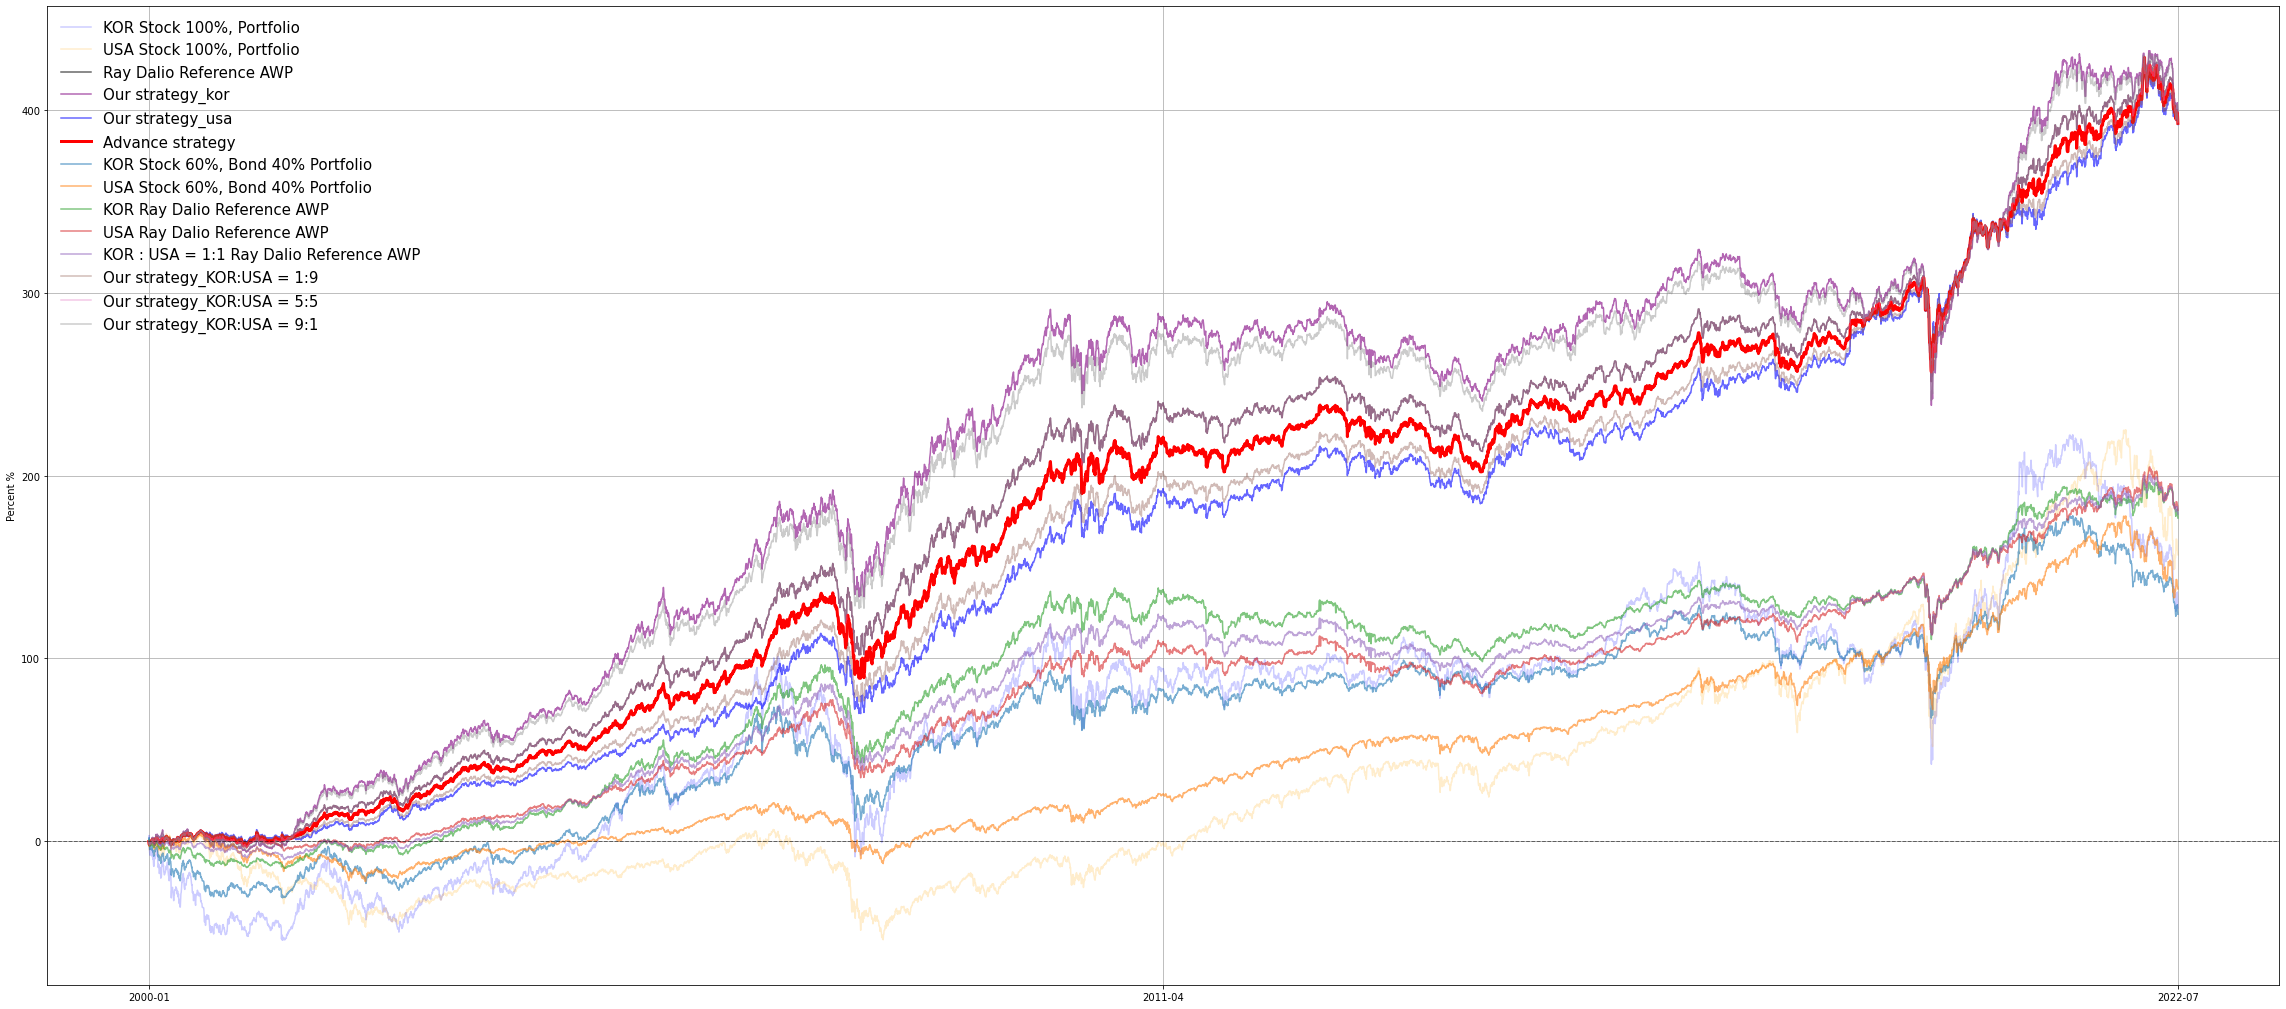

'\nmin 0.4 max 0.6 일때, 샤프지수 8.9929 으로 우리 advance 전략이제일 좋았음\nmin 0.3 max 0.7 일때, 8.9771 으로 우리전략이 젤 높음\nmin 0.2 max 0.8, 8.8642인데, KOR:USA = 5:5 의 샤프보다 낮으므로 버립니다 \n0.1,   0.9도 구림\n0.0,   1.0도 구림..\n\n'

In [5]:
backtesting = Strategy().Run()




 MDD는 2008년과 2020을 테스트 할 수 있습니다. 

 년도를 입력하세요 형식 : xxxx,  2008 or 2020 2008



한국주식 60%, 한국채권 10년 40%, 금 0%, 원자재 0% 포트폴리오 의 결과 
MDD %: -31.3556

미국주식 60%, 미국채권 10년 40%, 금 0%, 원자재 0% 포트폴리오 의 결과 
MDD %: -32.3645

한국주식 100%, 한국채권 10년 0%, 금 0%, 원자재 0% 포트폴리오 의 결과 
MDD %: -54.5118

미국주식 100%, 미국채권 10년 0%, 금 0%, 원자재 0% 포트폴리오 의 결과 
MDD %: -56.7896

아래 세개 레이달리오 올웨더  
------------------------------------------------
 
한국주식 30%, 한국채권 10년 50%, 금 10%, 원자재 10% 포트폴리오 의 결과 
MDD %: -21.4639

미국주식 30%, 미국채권 10년 50%, 금 10%, 원자재 10% 포트폴리오 의 결과 
MDD %: -20.9344

올웨더 전략 KOR:USA = 1:1 의 결과 
MDD %: -21.2012

---------------------------------------


 95%|█████████████████████████████████████████████████████████████████████████████▋    | 18/19 [00:01<00:00, 16.38it/s]


전략 kor 의 결과 
MDD %: -20.0237

전략 usa  의 결과 
MDD %: -20.5575

전략 KOR:USA = 1:9 의 결과 
MDD %: -20.3325

전략 KOR:USA = 5:5 의 결과 
MDD %: -19.8542

전략 KOR:USA = 9:1 의 결과 
MDD %: -19.9891

전략 advance  의 결과 
MDD %: -19.9209



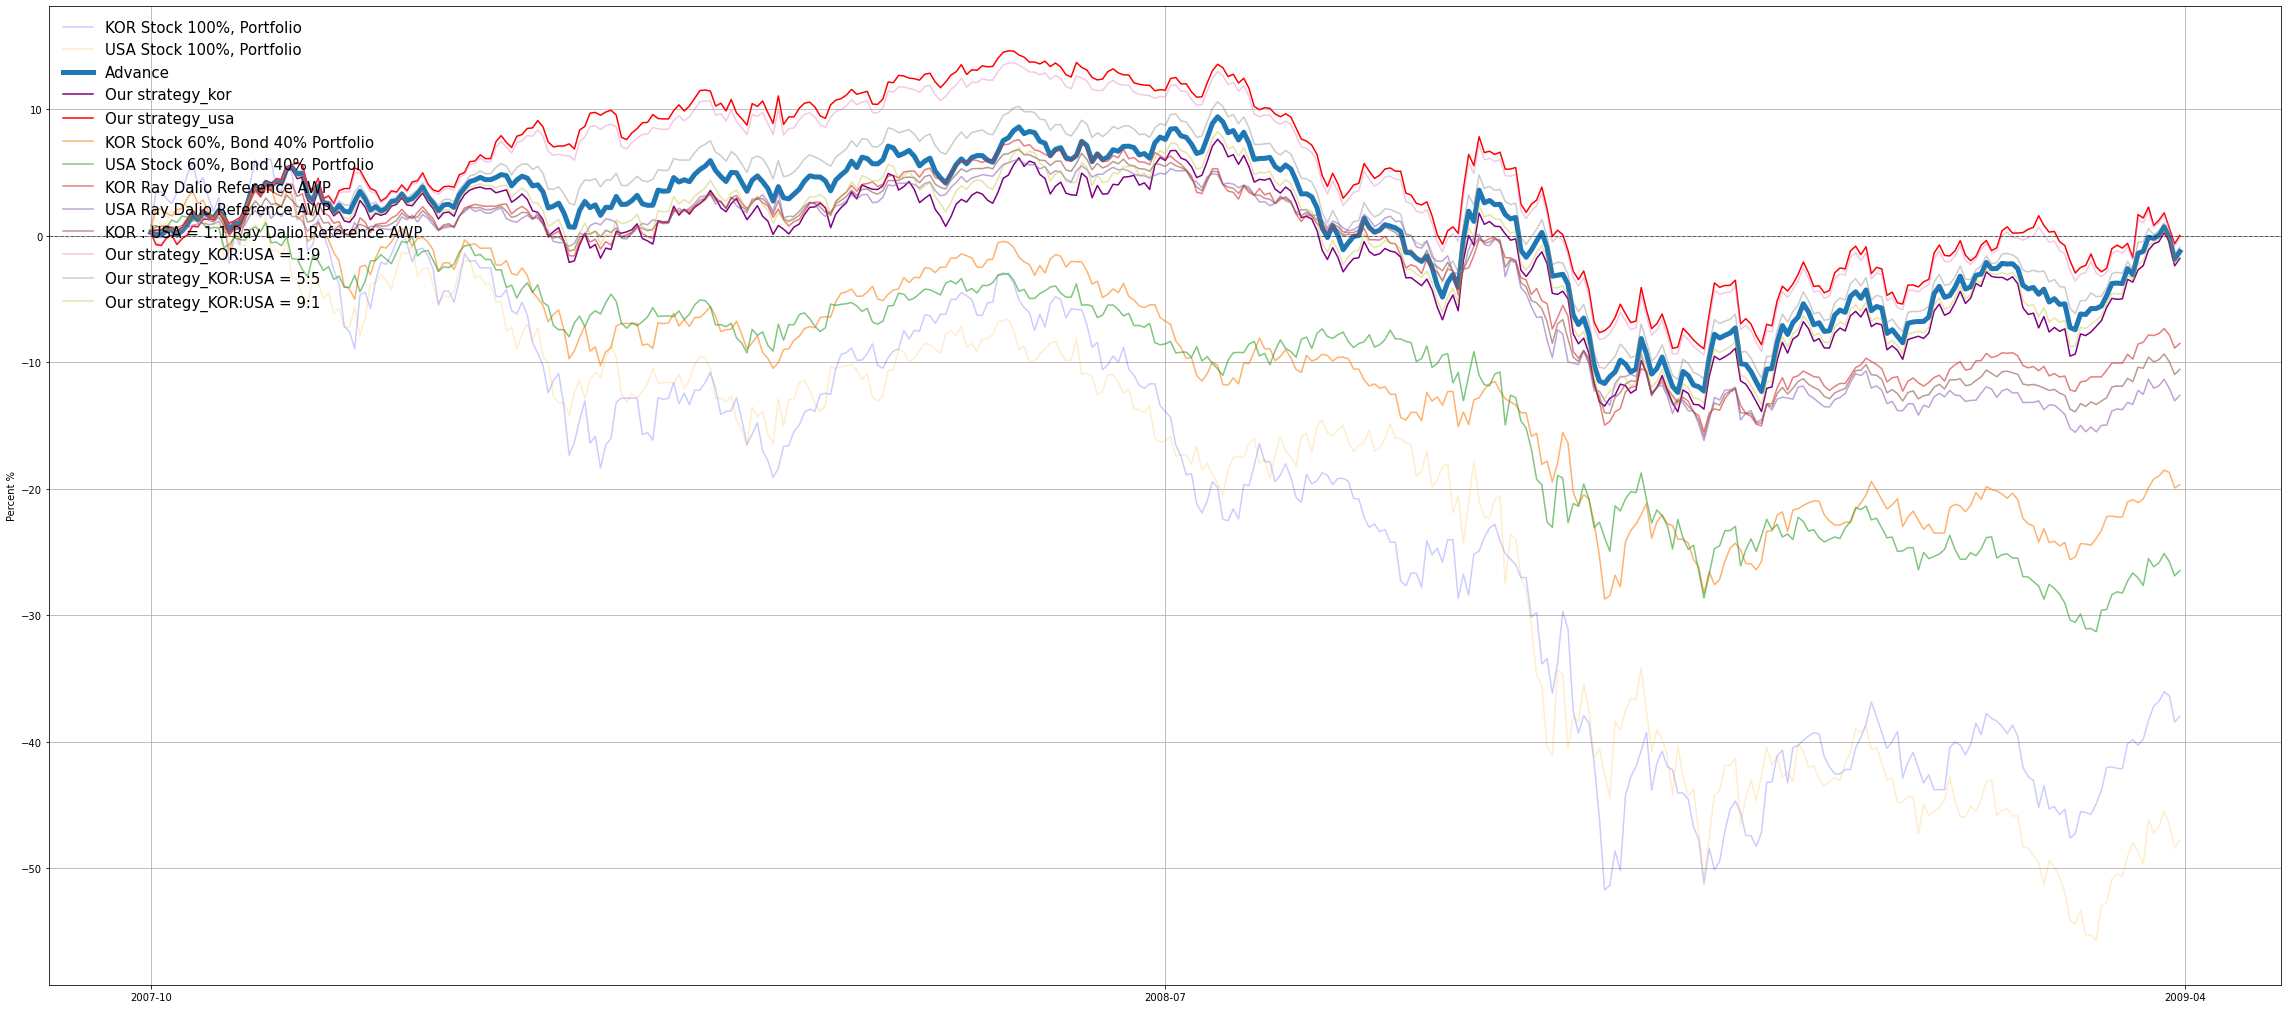

In [6]:
MDD().Run()


 MDD는 2008년과 2020을 테스트 할 수 있습니다. 

 년도를 입력하세요 형식 : xxxx,  2008 or 2020 2020



한국주식 60%, 한국채권 10년 40%, 금 0%, 원자재 0% 포트폴리오 의 결과 
MDD %: -21.5425

미국주식 60%, 미국채권 10년 40%, 금 0%, 원자재 0% 포트폴리오 의 결과 
MDD %: -20.6726

한국주식 100%, 한국채권 10년 0%, 금 0%, 원자재 0% 포트폴리오 의 결과 
MDD %: -35.6884

미국주식 100%, 미국채권 10년 0%, 금 0%, 원자재 0% 포트폴리오 의 결과 
MDD %: -33.9254

아래 세개 레이달리오 올웨더  
------------------------------------------------
 
한국주식 30%, 한국채권 10년 50%, 금 10%, 원자재 10% 포트폴리오 의 결과 
MDD %: -14.815

미국주식 30%, 미국채권 10년 50%, 금 10%, 원자재 10% 포트폴리오 의 결과 
MDD %: -13.9

올웨더 전략 KOR:USA = 1:1 의 결과 
MDD %: -13.7994

---------------------------------------


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00, 30.93it/s]

전략 kor 의 결과 
MDD %: -19.2371

전략 usa  의 결과 
MDD %: -11.0518

전략 KOR:USA = 1:9 의 결과 
MDD %: -11.4411

전략 KOR:USA = 5:5 의 결과 
MDD %: -14.0834

전략 KOR:USA = 9:1 의 결과 
MDD %: -18.2069

전략 advance  의 결과 
MDD %: -16.1458



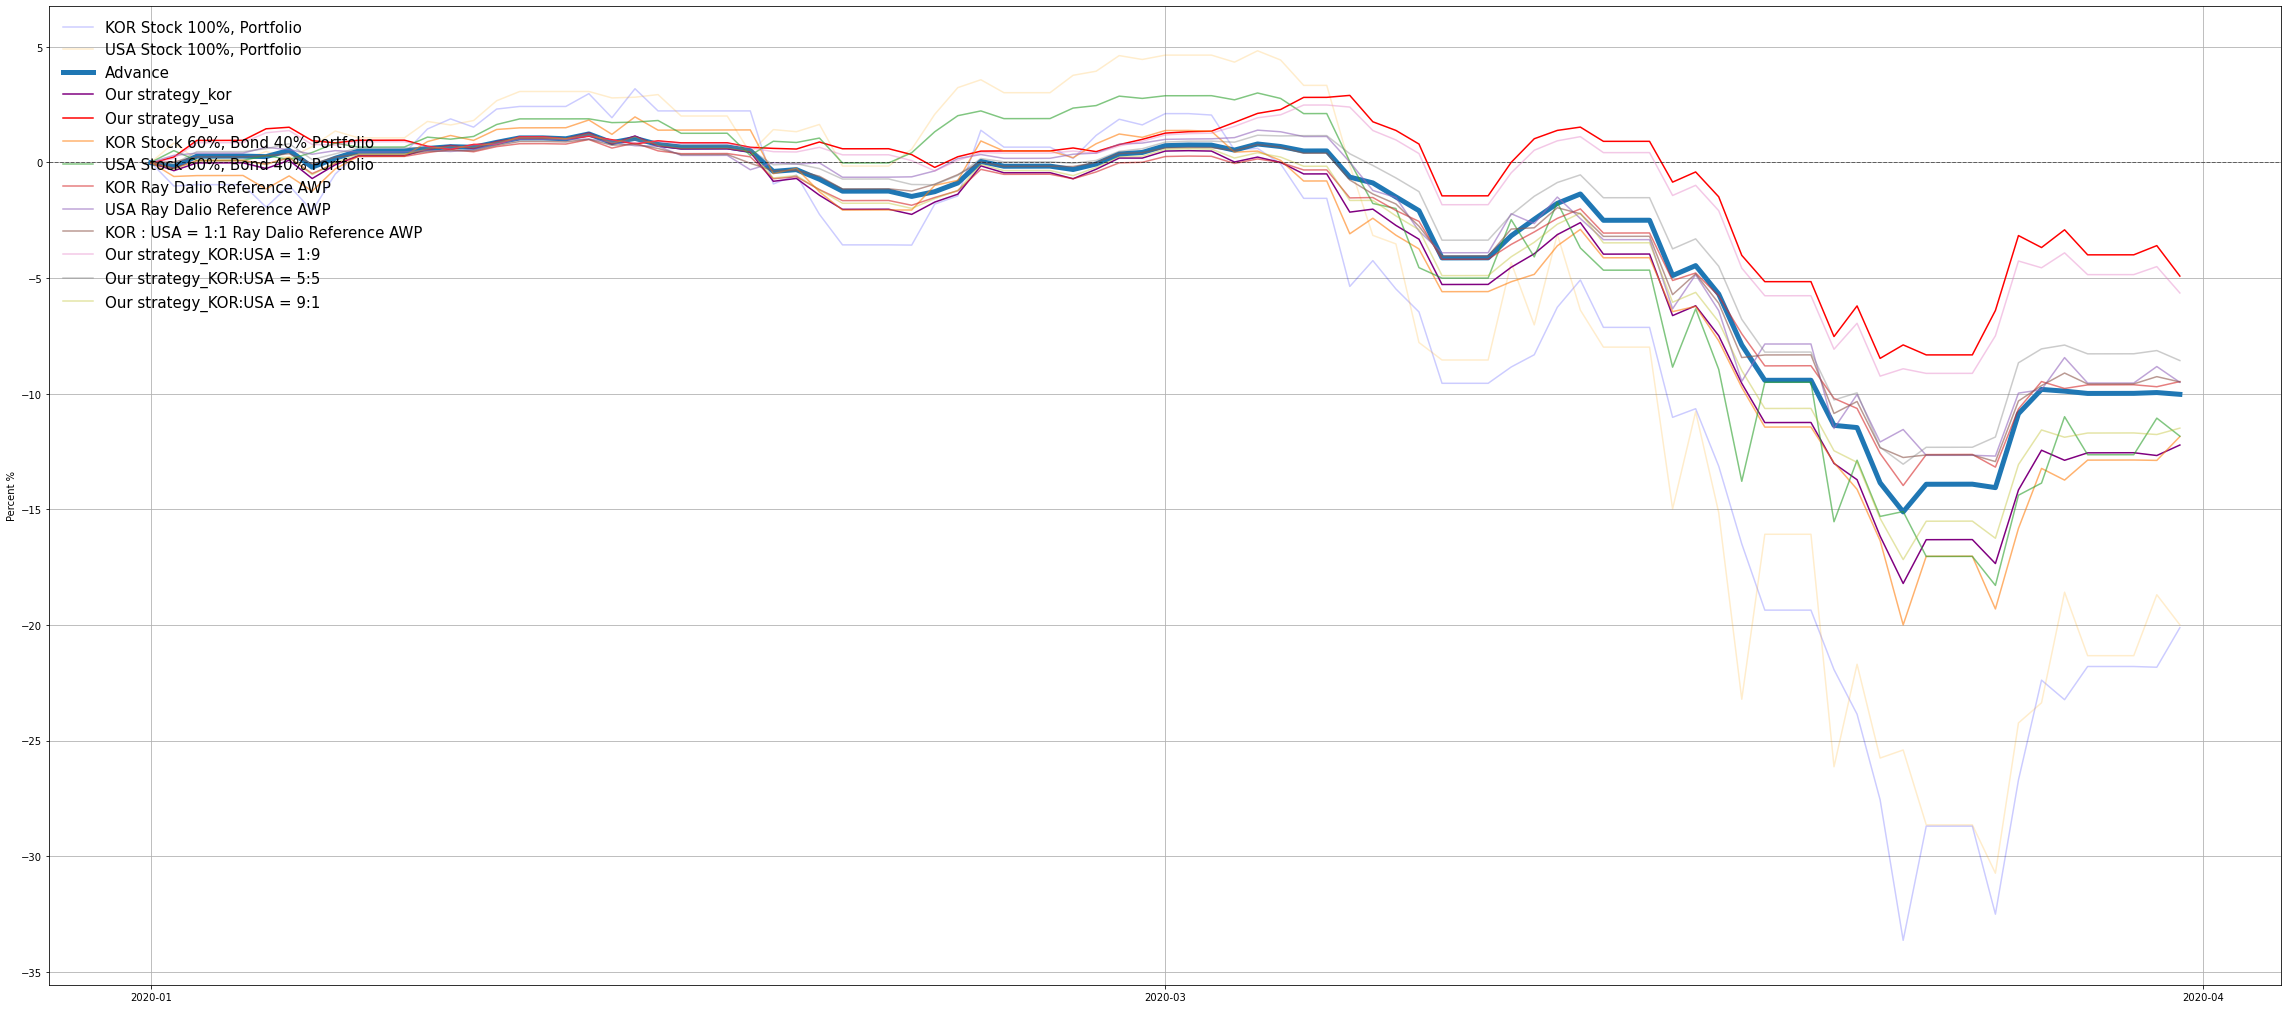

In [7]:
MDD().Run()